Gradient Boosting без сброса метамодели при повторном вызове fit, это удобно, чтобы отслеживать прогресс на графике. Также можно написать свою любую функцию потерь (сейчас реализовано только absolute и squared, но также можно и huber и любую другую симметричную к нулю функцию потерь). Лучше всего показала себя обычная MSE

In [3]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

In [ ]:
class my_GB:
    def __init__(self, lr=0.02, n_estimators=100, max_depth=1, criterion='absolute'):
        self.lr = lr
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.meta_model = []
        self.initial_pred = None
        self.criterion = criterion
        self._grad = {
            'absolute': lambda y_t, y_p: np.sign(y_p - y_t),
            'squared': lambda y_t, y_p: (y_p - y_t)
        }[criterion]

    def fit(self, X, y):
        if self.criterion == 'absolute':
            self.initial_pred = np.median(y)
        else:
            self.initial_pred = y.mean()

        for _ in range(self.n_estimators):
            y_pred = np.sum([self.lr * m.predict(X) for m in self.meta_model], axis=0) + self.initial_pred
            y_new = -self._grad(y, y_pred)

            b_m = DecisionTreeRegressor(max_depth=self.max_depth, criterion='squared_error')
            b_m.fit(X, y_new)

            self.meta_model.append(b_m)
        
    def predict(self, X):
        y_pred = np.sum([self.lr * m.predict(X) for m in self.meta_model], axis=0) + self.initial_pred
        return y_pred

In [318]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import pandas as pd

np.random.seed(42)
dataset = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, train_size=0.7, stratify=pd.qcut(dataset.target, q=5))

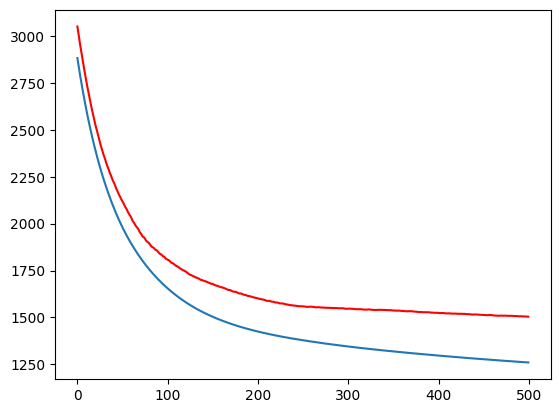

In [ ]:
import matplotlib.pyplot as plt

count = 500
train = []
test = []
kop = my_GB(n_estimators=1, criterion='squared')
for i in range(count):
    kop.fit(X_train, y_train)
    train.append(np.average(0.5*(y_train - kop.predict(X_train))**2))
    test.append(np.average(0.5*(y_test - kop.predict(X_test))**2))

plt.plot(range(count), train)
plt.plot(range(count), test, c='red')

In [320]:
train[-1], test[-1]

(np.float64(1260.0993755895902), np.float64(1504.0314395799498))

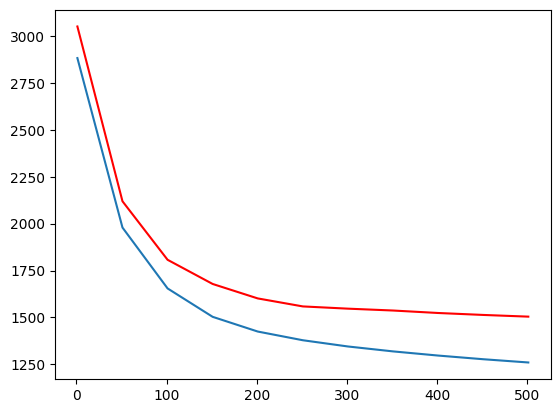

In [321]:
from sklearn.ensemble import GradientBoostingRegressor

count = 550
train = []
test = []
for i in range(1, count, 50):
    pok = GradientBoostingRegressor(n_estimators=i, learning_rate=0.02, max_depth=1)
    pok.fit(X_train, y_train)
    train.append(np.average(0.5*(y_train - pok.predict(X_train))**2))
    test.append(np.average(0.5*(y_test - pok.predict(X_test))**2))

plt.plot(range(1, count, 50), train)
plt.plot(range(1, count, 50), test, c='red')

In [322]:
train[-1], test[-1]

(np.float64(1259.7719469355713), np.float64(1504.1055186793028))